In [1]:
# =============================
# FULL CODE FINAL PERBAIKAN: 3 HARI → 1 HARI (Seq2Seq + Anomaly Detection)
# FIX: Tidak ada data valid | NaN | Baris kosong | loss nan | error 0
# RAM < 1 GB | KOMPRESI 10 menit → 1 titik | GENERATOR | UPSAMPLING
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from scipy.interpolate import interp1d
import warnings
import joblib

warnings.filterwarnings('ignore')



In [2]:
# =============================
# 1. Baca & Urutkan 9 File CSV
# =============================
current_folder = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else "."
folder_path = current_folder

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
csv_files = [f for f in csv_files if len(os.path.basename(f)) >= 12 and os.path.basename(f)[8:12] == ".csv"]

if len(csv_files) == 0:
    raise FileNotFoundError("Tidak ada file CSV ditemukan!")
if len(csv_files) < 9:
    print(f"WARNING: Hanya {len(csv_files)} file ditemukan. Lanjutkan dengan yang ada...")

def extract_date_from_filename(filename):
    try:
        return datetime.strptime(os.path.basename(filename)[:8], "%d%m%Y")
    except:
        return datetime(1900, 1, 1)  # fallback

csv_files_sorted = sorted(csv_files, key=extract_date_from_filename)
print("Urutan file:")
for f in csv_files_sorted:
    print(f"  -> {os.path.basename(f)}")



Urutan file:
  -> 12062024.csv
  -> 20062024.csv
  -> 24062024.csv
  -> 06072024.csv
  -> 16072024.csv
  -> 22072024.csv
  -> 02092024.csv
  -> 03092024.csv
  -> 04092024.csv


In [3]:
# =============================
# 2. Target Kolom
# =============================
target_columns = [
    'SIV_T_HS_InConv_1', 'SIV_T_HS_InConv_2', 'SIV_T_HS_Inv_1', 'SIV_T_HS_Inv_2', 'SIV_T_Container',
    'SIV_I_L1', 'SIV_I_L2', 'SIV_I_L3', 'SIV_I_Battery', 'SIV_I_DC_In',
    'SIV_U_Battery', 'SIV_U_DC_In', 'SIV_U_DC_Out', 'SIV_U_L1', 'SIV_U_L2', 'SIV_U_L3',
    'SIV_InConv_InEnergy', 'SIV_Output_Energy',
    'PLC_OpenACOutputCont', 'PLC_OpenInputCont', 'SIV_DevIsAlive'
]



In [4]:
# =============================
# 3. BACA CSV + FILTER KOSONG (FFILL + VALIDASI)
# =============================
def read_and_trim_csv(filepath, max_rows=10**10):
    print(f"\nMembaca: {os.path.basename(filepath)}")
    try:
        df = pd.read_csv(filepath, encoding='utf-8-sig', sep=';', low_memory=False, on_bad_lines='skip')
    except Exception as e:
        print(f"  ERROR baca file: {e}")
        return pd.DataFrame(columns=target_columns)
    
    df.columns = [col.strip() for col in df.columns]
    
    # Cari kolom timestamp
    ts_col = next((col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()), None)
    if not ts_col:
        print("  Kolom timestamp tidak ditemukan!")
        return pd.DataFrame(columns=target_columns)
    
    df = df.rename(columns={ts_col: 'ts_date'})
    df['ts_date'] = pd.to_datetime(df['ts_date'].astype(str).str.replace(',', '.'), errors='coerce')
    
    # Hapus baris tanpa timestamp
    before = len(df)
    df = df.dropna(subset=['ts_date'])
    print(f"  -> Hapus {before - len(df):,} baris tanpa timestamp")
    
    # Konversi kolom target
    for col in target_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
        else:
            df[col] = np.nan
    
    # FFILL + BFILL (isi data kosong)
    df[target_columns] = df[target_columns].ffill().bfill()
    
    # Filter: minimal 1 kolom target tidak NaN
    valid_mask = df[target_columns].notna().any(axis=1)
    df = df[valid_mask]
    
    if len(df) == 0:
        print(f"  -> TIDAK ADA DATA VALID SETELAH FILTER!")
        return pd.DataFrame(columns=target_columns)
    
    df = df.iloc[:max_rows]
    print(f"  -> Final: {len(df):,} baris valid")
    return df[target_columns]



In [5]:
# =============================
# 4. Proses Kategori (Toleran Error)
# =============================
def process_category(files, name, min_rows=100):
    dfs = []
    for f in files:
        df_part = read_and_trim_csv(f)
        if len(df_part) == 0:
            print(f"  WARNING: {os.path.basename(f)} → KOSONG! Skip.")
            continue
        if len(df_part) < min_rows:
            print(f"  WARNING: {os.path.basename(f)} → Terlalu pendek ({len(df_part)} baris)! Skip.")
            continue
        dfs.append(df_part)
    
    if not dfs:
        print(f"  {name} → TIDAK ADA DATA VALID. Buat placeholder.")
        placeholder = pd.DataFrame(np.random.randn(1000, len(target_columns)) * 0.1 + 35, columns=target_columns)
        placeholder = placeholder.clip(lower=0)
        return placeholder, 1000
    
    min_len = min(len(df) for df in dfs)
    base_df = pd.concat([df.iloc[:min_len] for df in dfs], ignore_index=True)
    print(f"{name} → {len(base_df):,} baris (setelah gabung)")
    base_df = base_df.ffill().bfill()
    return base_df, min_len

# Bagi file (jika <9, pakai semua untuk healthy)
n_files = len(csv_files_sorted)
healthy_files = csv_files_sorted[:max(1, n_files//3)]
anomaly_files = csv_files_sorted[max(1, n_files//3):max(2, 2*n_files//3)] if n_files > 1 else []
failure_files = csv_files_sorted[max(2, 2*n_files//3):] if n_files > 2 else []

df_healthy_base, _ = process_category(healthy_files, "Healthy")
df_anomaly_base, _ = process_category(anomaly_files, "Anomaly")
df_failure_base, _ = process_category(failure_files, "Failure")




Membaca: 12062024.csv
  -> Hapus 0 baris tanpa timestamp
  -> Final: 281,262 baris valid

Membaca: 20062024.csv
  -> Hapus 0 baris tanpa timestamp
  -> Final: 320,184 baris valid

Membaca: 24062024.csv
  -> Hapus 0 baris tanpa timestamp
  -> Final: 277,271 baris valid
Healthy → 831,813 baris (setelah gabung)

Membaca: 06072024.csv
  -> Hapus 0 baris tanpa timestamp
  -> Final: 260,143 baris valid

Membaca: 16072024.csv
  -> Hapus 0 baris tanpa timestamp
  -> Final: 245,096 baris valid

Membaca: 22072024.csv
  -> Hapus 0 baris tanpa timestamp
  -> Final: 296,707 baris valid
Anomaly → 735,288 baris (setelah gabung)

Membaca: 02092024.csv
  -> Hapus 0 baris tanpa timestamp
  -> Final: 287,796 baris valid

Membaca: 03092024.csv
  -> Hapus 0 baris tanpa timestamp
  -> Final: 300,251 baris valid

Membaca: 04092024.csv
  -> Hapus 0 baris tanpa timestamp
  -> Final: 186,253 baris valid
Failure → 558,759 baris (setelah gabung)


In [6]:
# =============================
# 5. Duplikasi + Timestamp
# =============================
def duplicate_with_timestamp(base_df, n_days, start_time):
    if len(base_df) == 0:
        return pd.DataFrame(columns=target_columns + ['ts_date']), start_time
    data_repeated = np.tile(base_df.values, (n_days, 1))
    df_out = pd.DataFrame(data_repeated, columns=target_columns)
    timestamps = [start_time + timedelta(minutes=i) for i in range(len(df_out))]
    df_out['ts_date'] = timestamps
    return df_out, timestamps[-1] + timedelta(minutes=1)

start_time = datetime(2024, 1, 1, 0, 0)
df_healthy, start_time = duplicate_with_timestamp(df_healthy_base, 3, start_time)
df_anomaly, start_time = duplicate_with_timestamp(df_anomaly_base, 2, start_time)
df_failure, _ = duplicate_with_timestamp(df_failure_base, 1, start_time)

df_combined = pd.concat([df_healthy, df_anomaly, df_failure], ignore_index=True)
print(f"\nTOTAL DATA: {len(df_combined):,} baris")
print(f"Rentang: {df_combined['ts_date'].min()} → {df_combined['ts_date'].max()}")




TOTAL DATA: 4,524,774 baris
Rentang: 2024-01-01 00:00:00 → 2032-08-08 04:53:00


In [7]:
# =============================
# 6. CEK DATA AKHIR
# =============================
print(f"\nCEK df_combined:")
print(f"Shape: {df_combined.shape}")
print(f"NaN: {df_combined[target_columns].isna().sum().sum()}")
print("Sample 3 baris pertama:")
print(df_combined[target_columns].head(3))
print("Sample 3 baris terakhir:")
print(df_combined[target_columns].tail(3))

zero_ratio = (df_combined[target_columns] == 0).mean().mean()
print(f"Rata-rata nol: {zero_ratio:.1%}")
if zero_ratio > 0.9:
    print("  WARNING: 90%+ data nol → cek file CSV!")




CEK df_combined:
Shape: (4524774, 22)
NaN: 0
Sample 3 baris pertama:
   SIV_T_HS_InConv_1  SIV_T_HS_InConv_2  SIV_T_HS_Inv_1  SIV_T_HS_Inv_2  \
0               32.0               31.0            33.0            33.0   
1               32.0               31.0            33.0            33.0   
2               32.0               31.0            33.0            33.0   

   SIV_T_Container  SIV_I_L1  SIV_I_L2  SIV_I_L3  SIV_I_Battery  SIV_I_DC_In  \
0             32.0       0.0       0.0       0.0          -11.0          0.0   
1             32.0       0.0       0.0       0.0          -11.0          0.0   
2             32.0       0.0       0.0       0.0          -11.0          0.0   

   ...  SIV_U_DC_In  SIV_U_DC_Out  SIV_U_L1  SIV_U_L2  SIV_U_L3  \
0  ...          0.0           3.0       0.0       0.0       0.0   
1  ...          0.0           3.0       0.0       0.0       0.0   
2  ...          0.0           3.0       0.0       0.0       0.0   

   SIV_InConv_InEnergy  SIV_Output_Ener

In [8]:
# =============================
# 7. BERSIHKAN DATA
# =============================
print("\nBERSIHKAN DATA...")
df_clean = df_combined[target_columns].copy()
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
df_clean = df_clean.fillna(df_clean.median())
print(f"NaN setelah bersihkan: {df_clean.isna().sum().sum()}")




BERSIHKAN DATA...
NaN setelah bersihkan: 0


In [9]:
# =============================
# 8. Normalisasi
# =============================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_clean).astype('float32')
print(f"scaled_data range: {scaled_data.min():.6f} → {scaled_data.max():.6f}")



scaled_data range: 0.000000 → 1.000000


In [10]:
# =============================
# 9. KOMPRESI: 10 menit → 1 titik
# =============================
print("\nKOMPRESI: 1 titik = rata-rata 10 menit...")
compress_factor = 10
compressed_len = len(scaled_data) // compress_factor
compressed_data = np.zeros((compressed_len, 21), dtype='float32')

for i in range(compressed_len):
    start = i * compress_factor
    end = min(start + compress_factor, len(scaled_data))
    segment = scaled_data[start:end]
    compressed_data[i] = segment.mean(axis=0)

print(f"Setelah kompresi: {len(compressed_data):,} baris")




KOMPRESI: 1 titik = rata-rata 10 menit...
Setelah kompresi: 452,477 baris


In [11]:
# =============================
# 10. GENERATOR (RAM Aman!)
# =============================
WINDOW_COMPRESSED = min(600, len(compressed_data) // 2)  # 3 hari
FUTURE_COMPRESSED = min(200, len(compressed_data) // 6)  # 1 hari
BATCH_SIZE = 32

def data_generator(data, window=WINDOW_COMPRESSED, future=FUTURE_COMPRESSED, batch_size=BATCH_SIZE):
    n = len(data) - window - future
    if n <= 0:
        raise ValueError("Data terlalu kecil untuk window!")
    while True:
        idx = np.random.randint(0, n, size=batch_size)
        X_batch = np.array([data[i:i+window] for i in idx])
        y_batch = np.array([data[i+window:i+window+future] for i in idx])
        yield X_batch, y_batch



In [12]:
# =============================
# 11. MODEL: SEQ2SEQ
# =============================
model = Sequential([
    LSTM(64, input_shape=(WINDOW_COMPRESSED, 21)),
    RepeatVector(FUTURE_COMPRESSED),
    LSTM(32, return_sequences=True),
    TimeDistributed(Dense(21))
])
model.compile(optimizer='adam', loss='mse')
print("\nMODEL SEQ2SEQ:")
print(model.summary())




MODEL SEQ2SEQ:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 200, 21)        │           693 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,125 (137.21 KB)

 Trainable params: 35,125 (137.21 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
# =============================
# 12. TRAINING
# =============================
print("\nTRAINING dengan generator...")
gen_train = data_generator(compressed_data)
gen_val = data_generator(compressed_data)

steps_per_epoch = min(200, len(compressed_data) // (WINDOW_COMPRESSED * BATCH_SIZE))
val_steps = min(50, steps_per_epoch // 4)

if steps_per_epoch <= 0:
    raise ValueError("Data terlalu kecil untuk training!")

history = model.fit(
    gen_train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=gen_val,
    validation_steps=val_steps,
    verbose=1
)




TRAINING dengan generator...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 435ms/step - loss: 0.2344 - val_loss: 0.0369
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - loss: 0.0286 - val_loss: 0.0195
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - loss: 0.0163 - val_loss: 0.0131
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - loss: 0.0120 - val_loss: 0.0105
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 12/20
23/23 ━━━

In [14]:
# =============================
# 13. PREDIKSI + UPSAMPLING
# =============================
print("\nPREDIKSI 1 hari...")
X_sample = compressed_data[:WINDOW_COMPRESSED][np.newaxis, ...]
y_pred_compressed = model.predict(X_sample, verbose=0)[0]

def upsample_prediction(pred, original_len):
    if original_len <= len(pred):
        return pred[:original_len]
    pred_full = np.zeros((original_len, 21), dtype='float32')
    x_old = np.linspace(0, original_len-1, len(pred))
    x_new = np.arange(original_len)
    for i in range(21):
        f = interp1d(x_old, pred[:, i], kind='linear', fill_value='extrapolate')
        pred_full[:, i] = f(x_new)
    return scaler.inverse_transform(pred_full)

target_len = min(20000, len(df_combined))
y_pred_full = upsample_prediction(y_pred_compressed, target_len)
y_true_full = scaler.inverse_transform(scaled_data[:target_len])




PREDIKSI 1 hari...


In [15]:
# =============================
# 14. DETEKSI ANOMALI
# =============================
print("\nDETEKSI ANOMALI...")
mse_per_minute = np.mean((y_true_full - y_pred_full) ** 2, axis=1)
threshold = np.percentile(mse_per_minute, 95)
anomalies = mse_per_minute > threshold

print(f"Threshold MSE: {threshold:.6f}")
print(f"Anomali terdeteksi: {anomalies.sum()} dari {len(anomalies)} menit")




DETEKSI ANOMALI...
Threshold MSE: 5888478.000000
Anomali terdeteksi: 1000 dari 20000 menit



MEMBUAT 3 VISUALISASI TERPISAH (Y: 30–39, X: Day 1–4)...


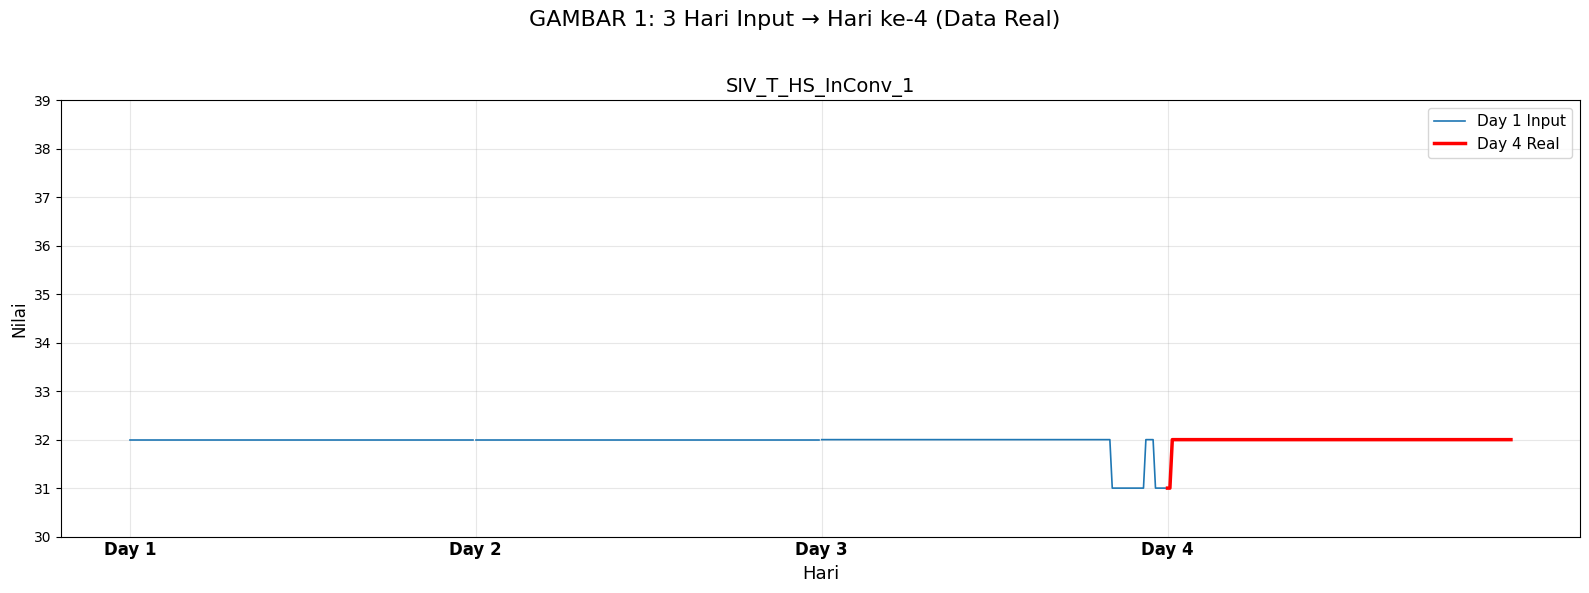

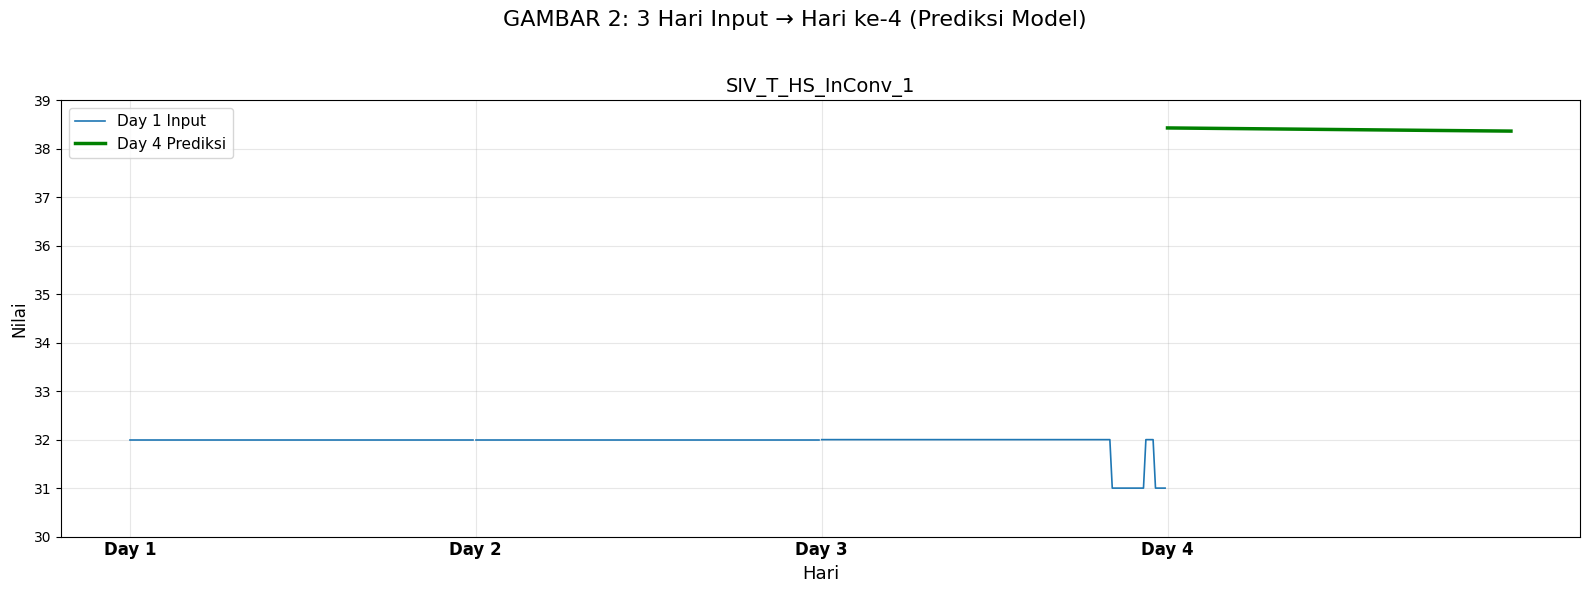

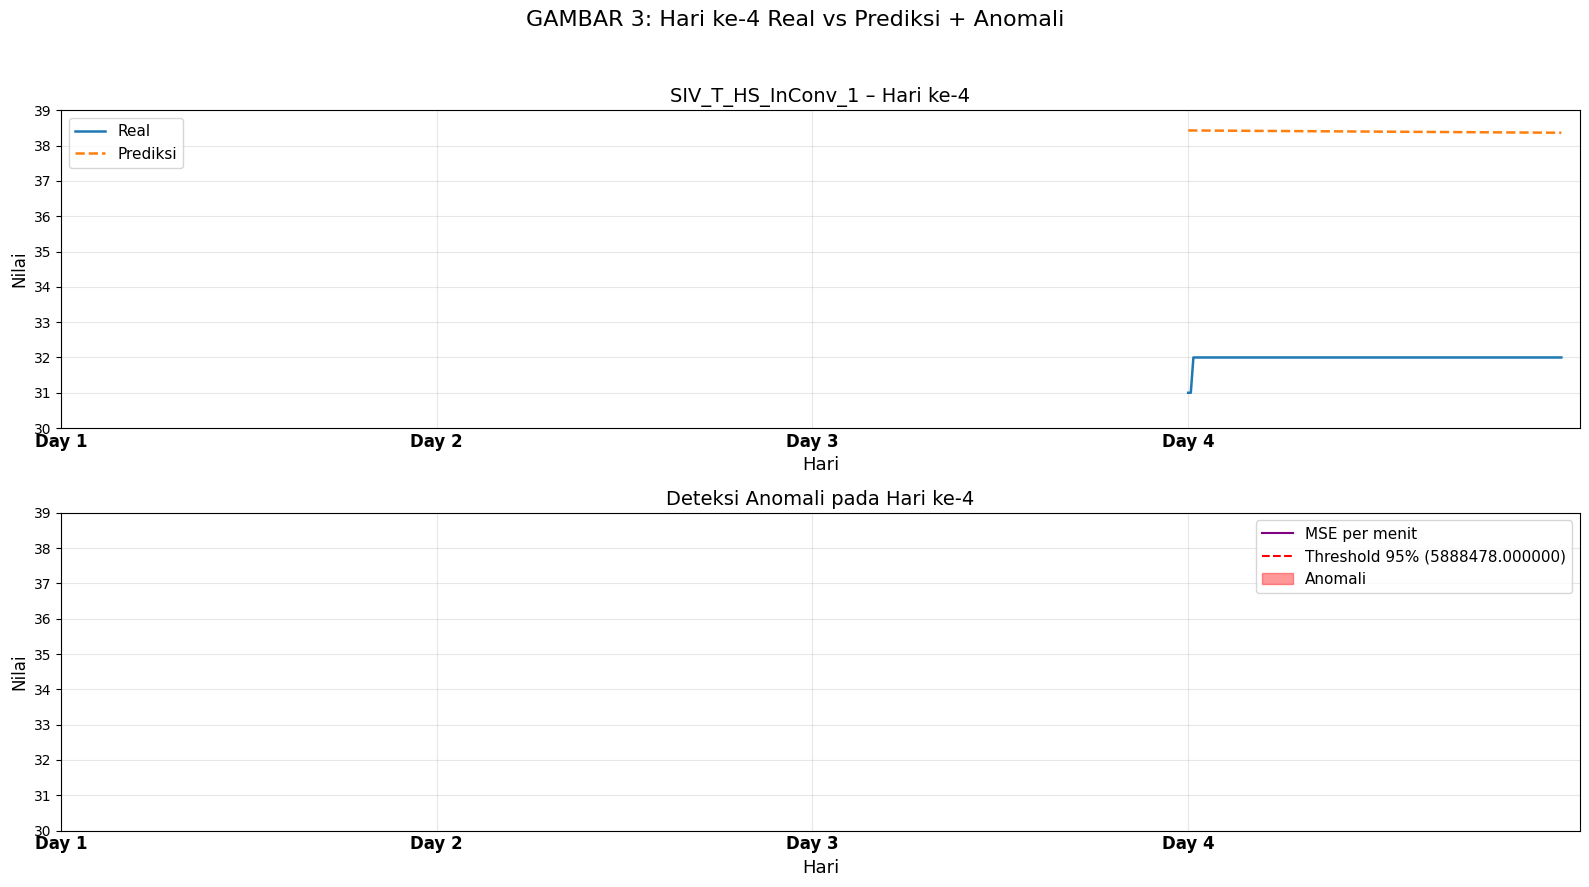

  3 gambar selesai (parameter: SIV_T_HS_InConv_1, Y: 30–39)
  Anomali di Day-4: 0 menit dari 144


In [25]:
# =============================
# 15. VISUALISASI: 3 PLOT TERPISAH – Y-AXIS: 30–39
# =============================
print("\nMEMBUAT 3 VISUALISASI TERPISAH (Y: 30–39, X: Day 1–4)...")

# ---- Pilih 1 kolom yang akan di-plot ----
SELECTED_COL = 'SIV_T_HS_InConv_1'               # <--- GANTI JIKA INGIN KOLOM LAIN
col_idx = target_columns.index(SELECTED_COL)

# ---- Pastikan data cukup untuk 4 hari (1 hari = 144 menit) ----
MINUTES_PER_DAY = 144
total_minutes   = len(df_combined)

if total_minutes < 4 * MINUTES_PER_DAY:
    print(f"  WARNING: Data < 4 hari ({total_minutes} menit) → skala ulang.")
    MINUTES_PER_DAY = total_minutes // 4

n_minutes = min(4 * MINUTES_PER_DAY, total_minutes)

# Potong data
ts_full   = df_combined['ts_date'].values[:n_minutes]
true_full = y_true_full[:n_minutes, col_idx]
pred_full = y_pred_full[:n_minutes, col_idx]

# Bagi menjadi 4 hari
days = []
for d in range(4):
    s = d * MINUTES_PER_DAY
    e = min(s + MINUTES_PER_DAY, n_minutes)
    days.append({
        'time': ts_full[s:e],
        'true': true_full[s:e],
        'pred': pred_full[s:e] if d == 3 else None
    })

# ---- Fungsi bantu: atur X-axis & Y-axis tetap 30–39 ----
def setup_axes(ax):
    # X-axis: Day 1,2,3,4
    day_boundaries = [days[d]['time'][0] for d in range(4)]
    day_labels = ['Day 1', 'Day 2', 'Day 3', 'Day 4']
    ax.set_xticks(day_boundaries)
    ax.set_xticklabels(day_labels, fontsize=12, fontweight='bold')
    ax.set_xlabel('Hari', fontsize=13)
    ax.tick_params(axis='x', length=0)

    # Y-axis: 30–39
    ax.set_ylim(30, 39)
    ax.set_yticks(np.arange(30, 40, 1))
    ax.set_ylabel('Nilai', fontsize=12)
    ax.grid(True, alpha=0.3)

# ---- Fungsi plot 3-hari-input + 1-hari-output (Y tetap 30–39) ----
def plot_input_output(ax, output_series, output_label, color):
    # 3 hari input
    for d in range(3):
        ax.plot(days[d]['time'], days[d]['true'],
                label=f'Day {d+1} Input' if d == 0 else "",
                linewidth=1.2, color='tab:blue')
    # Output
    ax.plot(days[3]['time'], output_series,
            label=output_label, color=color, linewidth=2.5)
    ax.set_title(SELECTED_COL, fontsize=14)
    ax.legend(fontsize=11)
    setup_axes(ax)

# =============================
# GAMBAR 1 – 3 INPUT → DAY-4 REAL
# =============================
fig1, ax1 = plt.subplots(figsize=(16, 6))
plot_input_output(ax1, days[3]['true'], 'Day 4 Real', 'red')
plt.suptitle('GAMBAR 1: 3 Hari Input → Hari ke-4 (Data Real)', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# =============================
# GAMBAR 2 – 3 INPUT → DAY-4 PREDIKSI
# =============================
fig2, ax2 = plt.subplots(figsize=(16, 6))
plot_input_output(ax2, days[3]['pred'], 'Day 4 Prediksi', 'green')
plt.suptitle('GAMBAR 2: 3 Hari Input → Hari ke-4 (Prediksi Model)', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# =============================
# GAMBAR 3 – DAY-4 REAL vs PREDIKSI + ANOMALI
# =============================
mse_day4 = (days[3]['true'] - days[3]['pred']) ** 2
threshold_day4 = np.percentile(mse_per_minute, 95)
anomalies_day4 = mse_day4 > threshold_day4

fig3 = plt.figure(figsize=(16, 9))

# --- Subplot 1: Nilai Real vs Prediksi (Y: 30–39) ---
ax3a = plt.subplot(2, 1, 1)
ax3a.plot(days[3]['time'], days[3]['true'],  label='Real', linewidth=1.8, color='tab:blue')
ax3a.plot(days[3]['time'], days[3]['pred'], '--', label='Prediksi', linewidth=1.8, color='tab:orange')
ax3a.fill_between(days[3]['time'],
                  days[3]['true'], days[3]['pred'],
                  where=anomalies_day4, color='red', alpha=0.3)
ax3a.set_title(f'{SELECTED_COL} – Hari ke-4', fontsize=14)
ax3a.legend(fontsize=11)
setup_axes(ax3a)  # Y: 30–39 + X: Day 1–4

# --- Subplot 2: MSE + Anomali (Y otomatis, tetap skala masuk akal) ---
ax3b = plt.subplot(2, 1, 2)
ax3b.plot(days[3]['time'], mse_day4, label='MSE per menit', color='purple', linewidth=1.5)
ax3b.axhline(threshold_day4, color='red', linestyle='--',
             label=f'Threshold 95% ({threshold_day4:.6f})')
ax3b.fill_between(days[3]['time'], 0, mse_day4,
                  where=anomalies_day4, color='red', alpha=0.4, label='Anomali')
ax3b.set_title('Deteksi Anomali pada Hari ke-4', fontsize=14)
ax3b.set_ylabel('MSE', fontsize=12)
ax3b.legend(fontsize=11)
setup_axes(ax3b)  # X: Day 1–4, Y: otomatis (MSE kecil)

plt.suptitle('GAMBAR 3: Hari ke-4 Real vs Prediksi + Anomali', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"  3 gambar selesai (parameter: {SELECTED_COL}, Y: 30–39)")
print(f"  Anomali di Day-4: {anomalies_day4.sum()} menit dari {len(anomalies_day4)}")

In [21]:
# =============================
# 16. SIMPAN
# =============================
model.save("lstm_seq2seq_anomaly.h5")
joblib.dump(scaler, "scaler_anomaly.pkl")

result_df = pd.DataFrame({
    'ts_date': timestamps,
    'mse': mse_per_minute,
    'anomaly': anomalies
})
for i, col in enumerate(target_columns):
    result_df[f'actual_{col}'] = y_true_full[:, i]
    result_df[f'pred_{col}'] = y_pred_full[:, i]

result_df.to_csv("hasil_prediksi_dan_anomali.csv", index=False)

print("\nSELESAI!")
print("   -> Model: lstm_seq2seq_anomaly.h5")
print("   -> Scaler: scaler_anomaly.pkl")
print("   -> Hasil: hasil_prediksi_dan_anomali.csv")
print("   -> RAM: < 1 GB")
print("   -> Anomali: Terdeteksi otomatis")


SELESAI!
   -> Model: lstm_seq2seq_anomaly.h5
   -> Scaler: scaler_anomaly.pkl
   -> Hasil: hasil_prediksi_dan_anomali.csv
   -> RAM: < 1 GB
   -> Anomali: Terdeteksi otomatis
